In [1]:
import jcopdl, luwiji

In [2]:
jcopdl.__version__, luwiji.__version__

('1.1.9', '1.1.8')

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [4]:
import torch
from torch import nn, optim

# import Data

In [5]:
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


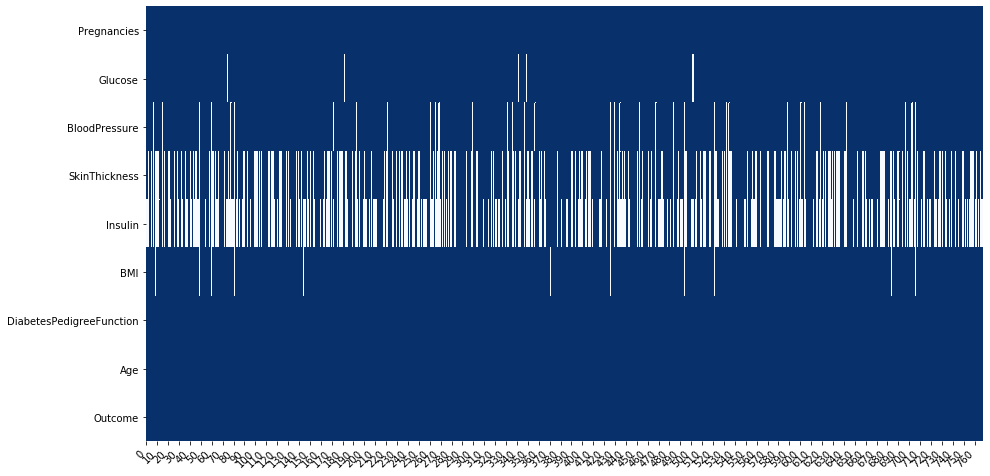

In [6]:
plot_missing_value(df)

In [7]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

# Dataset Splitting

In [8]:
df.drop(columns = ('Insulin'), inplace = True)

In [9]:
X = df.drop(columns="Outcome")
y = df.Outcome.values #for numpy values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

# Preprocess Data

In [10]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
353,1,90.0,62.0,12.0,27.2,0.580,24
711,5,126.0,78.0,27.0,29.6,0.439,40
373,2,105.0,58.0,40.0,34.9,0.225,25
46,1,146.0,56.0,NaN,29.7,0.564,29
682,0,95.0,64.0,39.0,44.6,0.366,22


In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

In [12]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [13]:
X_train

array([[1.00e+00, 9.00e+01, 6.20e+01, ..., 2.72e+01, 5.80e-01, 2.40e+01],
       [5.00e+00, 1.26e+02, 7.80e+01, ..., 2.96e+01, 4.39e-01, 4.00e+01],
       [2.00e+00, 1.05e+02, 5.80e+01, ..., 3.49e+01, 2.25e-01, 2.50e+01],
       ...,
       [1.00e+00, 9.70e+01, 7.00e+01, ..., 3.81e+01, 2.18e-01, 3.00e+01],
       [1.00e+01, 1.11e+02, 7.00e+01, ..., 2.75e+01, 1.41e-01, 4.00e+01],
       [4.00e+00, 1.44e+02, 5.80e+01, ..., 2.95e+01, 2.87e-01, 3.70e+01]])

# Dataset and Data Loader

In [14]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [15]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train) 
y_test = torch.LongTensor(y_test)

# long -> used for interger tensor (0, 1) if using softmax

In [16]:
train_set = TensorDataset (X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset (X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

# Training Preparation

## Model

In [17]:
from torch import nn

In [18]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
)
#LogSoftmax for multiclass clasification

## Criterion

#### criterion = nn.MSELoss -> model ended by linear -> for regression
#### criterion = nn. NLLLoss -> model ended by logsoftmax -> for multiclass clf
#### criterion = nn.bCELoss -> model ended by sigmodi ->  for binary clf, multilabel clf

In [19]:
criterion = nn.NLLLoss()

## Optimizer

In [20]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Training 

In [23]:
epochs = 1000
train_cost, test_cost = [], []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in trainloader:
        output = model(feature) # feed forward
        loss  = criterion(output, target)
        loss.backward() # Backpropagation

        optimizer.step # update weight
        optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))
    
    with torch.no_grad():
        model.eval()
        cost = 0
        for feature, target in testloader:
            output = model(feature) # feed forward
            loss  = criterion(output, target)
            
            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_set))
        
        
    print(f"\rEpoch: {i+1:4}/{epochs:4} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}", end =" ")

Epoch: 1000/1000 | train_cost: 0.7895 | test_cost: 0.7795 

In [24]:
import matplotlib.pyplot as plt

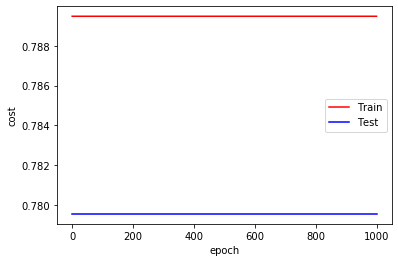

In [25]:
plt.plot(train_cost, 'r-', label ='Train')
plt.plot(test_cost, 'b-', label ='Test')
plt.xlabel('epoch'); plt.ylabel('cost'); plt.legend()

In [26]:
with torch.no_grad():
    model.eval()
    output = model(X_test)

In [27]:
pred = output.argmax(1)
pred 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Accucary

In [28]:
acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.6494)

# Minimize Overfit with Dropout

In [29]:
from luwiji.neural_network import illustration

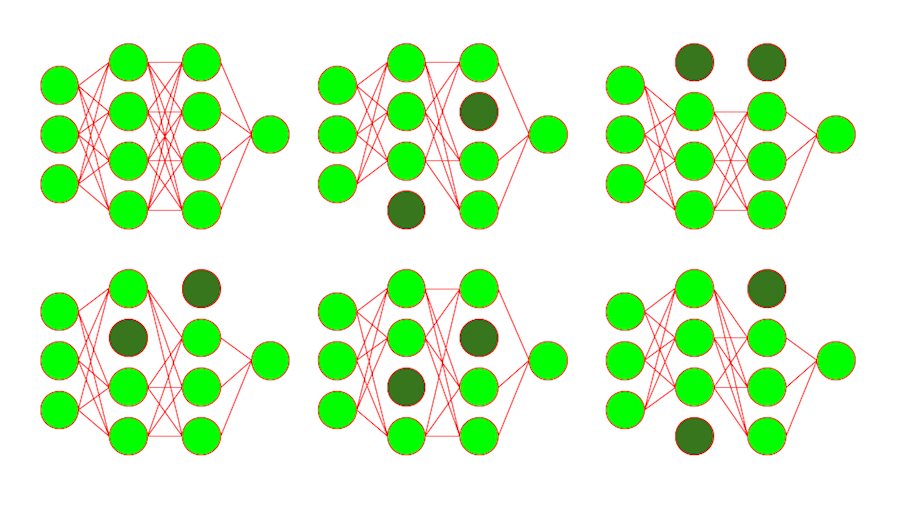

In [30]:
illustration.dropout

# MCO With Dropout

In [31]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [33]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output = model (feature)
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [34]:
epochs = 1000
train_cost, test_cost = [], []
train_acc, test_acc = [], []
for i in range(epochs):
    cost, acc = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_acc.append(acc)
    with torch.no_grad():
        cost, acc = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_acc.append(acc)
        
    print(f"\rEpoch:{i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}) | "
          f"train_acc: {train_acc[-1]:.4f} | test_acc: {test_acc[-1]:.4f}", end = " ")

Epoch:1000/1000 | train_cost: 0.5544 | test_cost: 0.6963) | train_acc: 0.7410 | test_acc: 0.6494 

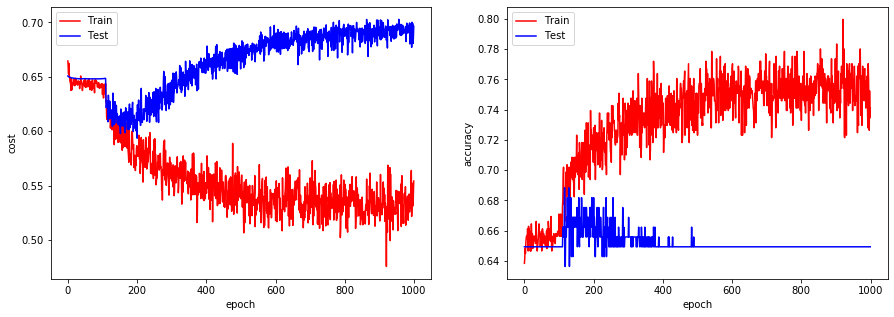

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label = "Train")
plt.plot(test_cost, 'b-', label = "Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();

plt.subplot(122)
plt.plot(train_acc, 'r-', label = "Train")
plt.plot(test_acc, 'b-', label = "Test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend();

# Save & Load Model

## Save Weight

In [36]:
import os

In [37]:
os.makedirs('model', exist_ok = True)

In [38]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-9.5803e-02, -4.1108e-04,  2.2912e-01,  5.3337e-02, -4.5075e-01,
                       -8.5390e-01, -2.4206e-01],
                      [ 7.4308e-02,  1.9955e-01,  2.7149e-02, -2.3330e-02,  3.0121e-01,
                        6.9936e-01,  1.6537e-01],
                      [-2.6855e-01,  2.3798e-02, -2.5798e-01,  1.1655e-01, -1.3016e-01,
                        1.1581e-01, -7.8746e-02],
                      [ 3.1348e-01, -2.2402e-01, -2.2542e-01, -2.2543e-01,  3.3996e-01,
                        1.2596e-01,  3.6370e-01],
                      [-3.1193e-01, -3.7489e-01, -2.9571e-01, -2.5425e-01,  1.5309e-01,
                        1.3534e-01,  3.1406e-01],
                      [-2.4463e-01, -3.0877e-01,  1.4106e-01, -2.1176e-01,  1.6754e-01,
                       -1.2986e-01,  1.5908e-01],
                      [-2.7503e-01, -2.3553e-01,  9.6906e-02,  6.8196e-02, -1.0450e-01,
                        1.9525e-01,  2.2436e-01],
        

In [39]:
torch.save(model.state_dict(), 'model/weights.pth')

In [40]:
log = {
    'train_cost' : train_cost,
    'test_cost' : test_cost,
    'train_acc' : train_acc,
    'test_acc' : test_acc
}
torch.save(log, 'model/logs.pth')

## Load Model

In [41]:
#load architecture first
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
)

In [42]:
 weights = torch.load('model/weights.pth', map_location = 'cpu')

In [43]:
model.load_state_dict(weights)
model = model.to(device)

In [44]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1)
    acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.6494)